In [1]:
from typing import Tuple

import pandas as pd
from utils.dataset_utils import DatasetUtils
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from torch import nn
import numpy as np

## Plot all the model results

In [30]:
# Define constants
START_DATE_BOARD = '2022-11-03'
END_DATE_BOARD = '2023-06-15'
RANDOM_STATE = 42

In [31]:
df_final = pd.DataFrame(columns=['timestamp', 'y', 'y_sensor', 'y_ann', 'y_vqr', 'y_lstm', 'y_qlstm', 'y_lstm-d'])

### Re-build all the dataset used to train the models

In [32]:
def build_dataset_hourly() -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_sensors = pd.read_csv('../resources/dataset/unique_timeseries_by_median_hours.csv')
    df_sensors.timestamp = pd.to_datetime(df_sensors.timestamp)
    df_sensors.timestamp += pd.Timedelta(hours=1)
    df_arpa = DatasetUtils.build_arpa_dataset('../resources/dataset/arpa/Dati PM10_PM2.5_2020-2022.csv', '../resources/dataset/arpa/Torino-Rubino_Polveri-sottili_2023-01-01_2023-06-30.csv', START_DATE_BOARD, END_DATE_BOARD)

    df = df_sensors.merge(df_arpa, left_on=['timestamp'], right_on=['timestamp'])
    df.rename(columns={"data": "x", "pm25": "y"}, inplace=True)
    # Slide ARPA data 1 hour plus
    df['y'] = DatasetUtils.slide_plus_1hours(df['y'], df['x'][0])
    return df, df_arpa

def build_dataset_hourly_all_features() -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_sensors = pd.read_csv('../resources/dataset/unique_timeseries_by_median_hours_all_attributes.csv')
    df_sensors.timestamp = pd.to_datetime(df_sensors.timestamp)
    df_sensors.timestamp += pd.Timedelta(hours=1)
    df_arpa = DatasetUtils.build_arpa_dataset('../resources/dataset/arpa/Dati PM10_PM2.5_2020-2022.csv', '../resources/dataset/arpa/Torino-Rubino_Polveri-sottili_2023-01-01_2023-06-30.csv', START_DATE_BOARD, END_DATE_BOARD)

    df = df_sensors.merge(df_arpa, left_on=['timestamp'], right_on=['timestamp'])
    df.rename(columns={"pm25_x": "x", "pm25_y": "y"}, inplace=True)
    # Slide ARPA data 1 hour plus
    df['y'] = DatasetUtils.slide_plus_1hours(df['y'], df['x'][0])
    return df, df_arpa

In [33]:
df, _ = build_dataset_hourly()
df_final['timestamp'] = df['timestamp']
df_final['y'] = df['y']
df_final['y_sensor'] = df['x']

## LSTM

In [34]:
# Build the same dataset
df, _ = build_dataset_hourly()
input_data = df.drop(['timestamp'], axis=1)
targets = df.y.values

In [35]:
from utils.tuning_utils import TuningUtils
from model.train.LSTM_trainer import LSTM_trainer
from model.LSTM import MyLSTM
from model.train.hyperparams.lstm_hyperparams import LSTM_Hyperparameters

hyperparams = LSTM_Hyperparameters(
    {
        'TRAIN_SIZE': 0.70,
        'LEARNING_RATE': 0.001,
        'OPTIMIZER': 'adam',
        'CRITERION': 'l1',
        'HIDDEN_SIZE': 600,
        'NUM_EPOCHS': 450,
        'T': 3
    }
)
model = MyLSTM(input_data.shape[1], hyperparams['HIDDEN_SIZE'], 2, hyperparams['OUTPUT_SIZE'])
model.load_state_dict(torch.load('../model/checkpoints/LSTM_TUNING_20231215_131022/LSTM_TUNING_20231215_131022_2023-12-15_13-24.pt'))

optimizer = TuningUtils.choose_optimizer(hyperparams.hyperparameters, model)
criterion = TuningUtils.choose_criterion(hyperparams.hyperparameters)
trainer = LSTM_trainer(model, name='LSTM_model', hyperparameters=hyperparams, optimizer=optimizer, criterion=criterion)

LSTM_model - Using cpu device


In [36]:
# Build dataset
D = input_data.shape[1]
N = len(input_data) - hyperparams['T']
X = np.zeros((N, hyperparams['T'], D))
# y = np.zeros((N, 1))
for t in range(N):
    X[t, :, :] = input_data[t:t + hyperparams['T']]
    # y[t] = (targets[t + hyperparams['T']])
X = torch.from_numpy(X.astype(np.float32))
# y = torch.from_numpy(y.astype(np.float32))

### Predict values

In [37]:
predictions = trainer.predict(X)
predictions = np.insert(predictions, 0, values=[0 for _ in range(hyperparams['T'])])
df['y_pred'] = predictions
df_final['y_lstm'] = predictions

In [38]:
# count weights
for i in model.named_parameters():
    print(len(i[1]), i[0])

2400 rnn.weight_ih_l0
2400 rnn.weight_hh_l0
2400 rnn.bias_ih_l0
2400 rnn.bias_hh_l0
2400 rnn.weight_ih_l1
2400 rnn.weight_hh_l1
2400 rnn.bias_ih_l1
2400 rnn.bias_hh_l1
1 fc.weight
1 fc.bias


### Plot the LSTM values

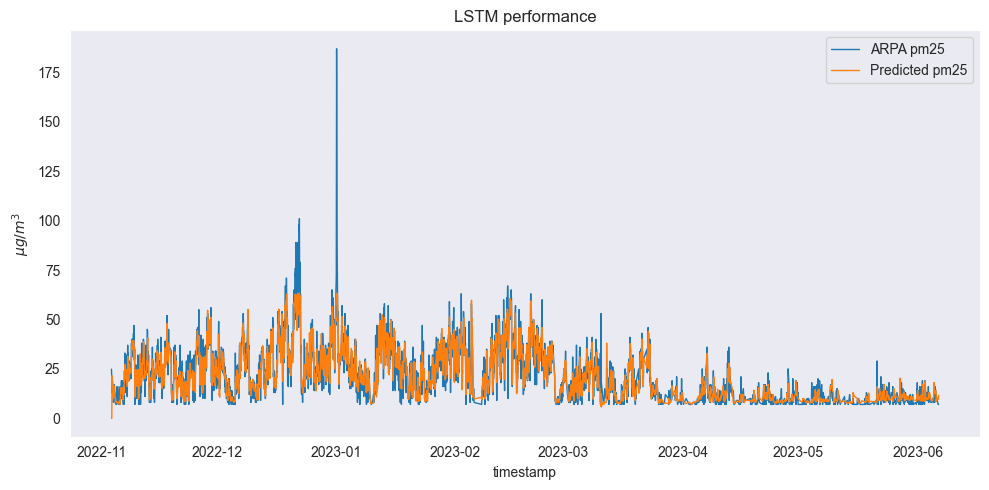

In [39]:
plot_df = df[['timestamp', 'y', 'y_pred']]
plot_df.set_index('timestamp', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(plot_df['y'], label='ARPA pm25', linewidth=1)
ax.plot(plot_df['y_pred'], label='Predicted pm25', linewidth=1)
ax.set_xlabel('timestamp')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title(f'LSTM performance')
ax.legend(loc='upper right')
ax.grid()
fig.tight_layout()
plt.show()

## VQR Linear model

### Scaling the dataset

In [40]:
from sklearn.preprocessing import MinMaxScaler

df, _ = build_dataset_hourly_all_features()
df.drop(['timestamp'], axis=1, inplace=True)
# Scale the features between -1 and +1
scaler = MinMaxScaler(feature_range=(-1, 1))
rescaledX = scaler.fit_transform(df)
df = pd.DataFrame(rescaledX, columns=df.columns)
# Split dataset
X = df.loc[:, df.columns != "y"].values
X = torch.from_numpy(X).type(torch.double)

In [41]:
from model.train.VQR_trainer import VQR_trainer
from model.VQRLinear import VQRLinearModel
from model.train.hyperparams.vqr_hyperparams import VQR_Hyperparameters

N_QUBITS = 4 # one qubit for each input feature
hyperparams = VQR_Hyperparameters(
    {
        'TRAIN_SIZE': 0.75,
        'LEARNING_RATE': 0.01,
        'OPTIMIZER': 'adam',
        'CRITERION': 'mse',
        'NUM_EPOCHS': 200,
        'NUM_LAYERS': 4,
        'BATCH_SIZE': 10
    }
)
model = VQRLinearModel(N_QUBITS, layers=hyperparams['NUM_LAYERS'], duplicate_qubits=hyperparams['DUPLICATE_QUBITS'])
model.load_state_dict(torch.load('../model/checkpoints/VQR_LINEAR_TUNING_20240313_173434/VQR_LINEAR_TUNING_20240313_173434_2024-03-14_14-54.pt'))

<All keys matched successfully>

### Predict values

In [42]:
model.eval()
with torch.no_grad():
    df['y_pred'] = model(X)

### Rescale back into original range

In [43]:
y_pred_scaled = scaler.inverse_transform(df.loc[:, df.columns != "y"].values)[:, -1]
df, _ = build_dataset_hourly_all_features()
df['y_pred'] = y_pred_scaled
df_final['y_vqr'] = y_pred_scaled

### Plot the VQR's results wrt ARPA

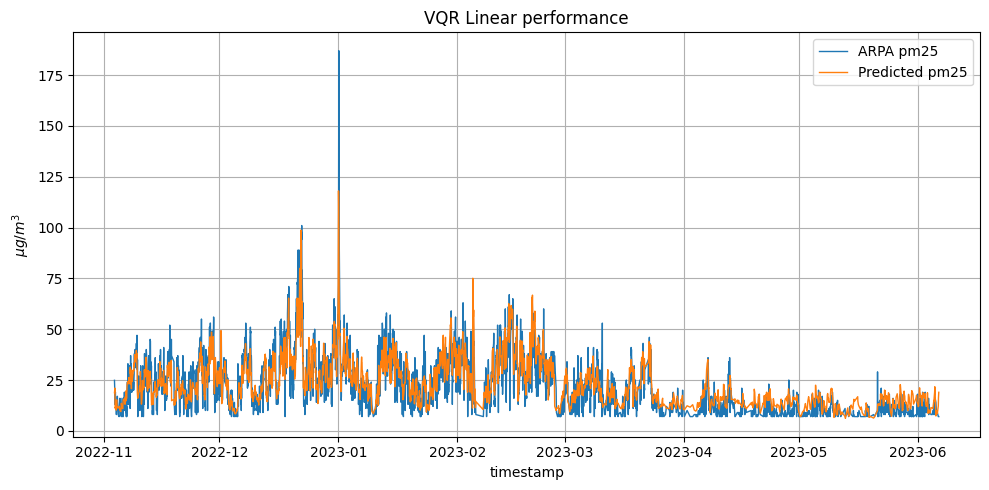

In [218]:
plot_df = df[['timestamp', 'y', 'y_pred']]
plot_df.set_index('timestamp', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(plot_df['y'], label='ARPA pm25', linewidth=1)
ax.plot(plot_df['y_pred'], label='Predicted pm25', linewidth=1)
ax.set_xlabel('timestamp')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title(f'VQR Linear performance')
ax.legend(loc='upper right')
ax.grid()
fig.tight_layout()
plt.show()

## ANN2 model

In [44]:
df, _ = build_dataset_hourly_all_features()
df2 = df.drop(['timestamp'], axis=1)
X = df2.loc[:, df2.columns != "y"].values
X = torch.from_numpy(X.astype(np.float32)).type(torch.float)

In [45]:
from model.ANN import MyNeuralNetwork
from model.train.hyperparams.ann_hyperparams import ANN_Hyperparameters

NUM_FEATURES = 4  # pm25, temperature, humidity, pressure
hyperparams = ANN_Hyperparameters(
    {
        'TRAIN_SIZE': 0.75,
        'LEARNING_RATE': 0.0001,
        'OPTIMIZER': 'sgd',
        'CRITERION': 'l1',
        'HIDDEN_SIZE': 30,
        'HIDDEN_SIZE_2': 15,
        'HIDDEN_SIZE_3': 5,
        'NUM_EPOCHS': 200,
        'BATCH_SIZE': 10
    }
)
model = MyNeuralNetwork(NUM_FEATURES, 1, hyperparams['HIDDEN_SIZE'], hyperparams['HIDDEN_SIZE_2'],
                        hyperparams['HIDDEN_SIZE_3'])
model.load_state_dict(torch.load('../model/checkpoints/ANN_hourly_all_feats_20240105_173754/ANN_hourly_all_feats_20240105_173754_2024-01-05_17-38.pt'))

<All keys matched successfully>

### Predict values

In [46]:
model.eval()
with torch.no_grad():
    predictions = model(X)
    df['y_pred'] = predictions
    df_final['y_ann'] = predictions

### Plot the ANN#2 values

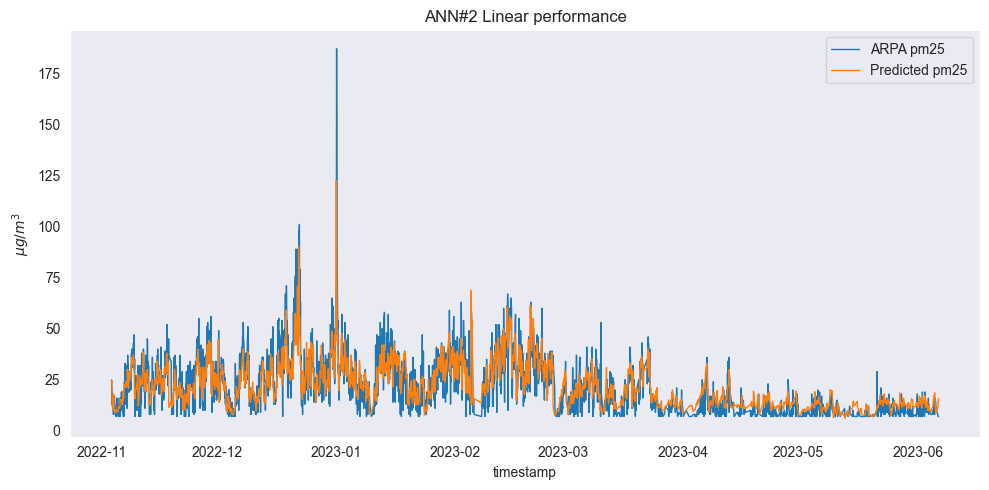

In [18]:
plot_df = df[['timestamp', 'y', 'y_pred']]
plot_df.set_index('timestamp', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(plot_df['y'], label='ARPA pm25', linewidth=1)
ax.plot(plot_df['y_pred'], label='Predicted pm25', linewidth=1)
ax.set_xlabel('timestamp')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title(f'ANN#2 Linear performance')
ax.legend(loc='upper right')
ax.grid()
fig.tight_layout()
plt.show()

## QLSTM model

In [47]:
# Build the same dataset
df, _ = build_dataset_hourly()
input_data = df.drop(['timestamp'], axis=1)
targets = df.y.values

In [48]:
from model.train.QLSTM_trainer import QLSTM_trainer
from model.QLSTM import QLSTM
from model.train.hyperparams.qlstm_hyperparams import QLSTM_Hyperparameters

hyperparams = QLSTM_Hyperparameters(
    {
        'TRAIN_SIZE': 0.7,
        'LEARNING_RATE': 0.01,
        'NUM_EPOCHS': 400,
        'HIDDEN_SIZE': 15,
        'OPTIMIZER': 'adam',
        'CRITERION': 'l1',
        'T': 5,
        'N_QUBITS': 7,
        'N_QLAYERS': 5
    }
)
model = QLSTM(input_data.shape[1], hidden_size=hyperparams['HIDDEN_SIZE'], n_qubits=hyperparams['N_QUBITS'],
              n_qlayers=hyperparams['N_QLAYERS'], batch_first=True, ansatz='strongly')
model.load_state_dict(torch.load('../model/checkpoints/QLSTM_STRONGLY_POWERED_20240226_220944/QLSTM_STRONGLY_POWERED_20240226_220944_2024-02-26_23-46.pt'))

optimizer = TuningUtils.choose_optimizer(hyperparams.hyperparameters, model)
criterion = TuningUtils.choose_criterion(hyperparams.hyperparameters)
trainer = QLSTM_trainer(model, name=
                        'QLSTM_strongly_model', hyperparameters=hyperparams, optimizer=optimizer, criterion=criterion)
# count weights
sum_weights = 0
for i in model.named_parameters():
    print(len(i[1]), i[0])
    sum_weights += len(i[1])
print('Total weights', sum_weights)

Choose "strongly" type of ansatz
QLSTM_strongly_model - Using cpu device
1 fc1.weight
1 fc1.bias
7 clayer_in.weight
7 clayer_in.bias
5 vqc_forget.weights
5 vqc_input.weights
5 vqc_update.weights
5 vqc_output.weights
15 clayer_out.weight
15 clayer_out.bias
Total weights 66


In [49]:
# Build dataset
D = input_data.shape[1]
N = len(input_data) - hyperparams['T']
X = np.zeros((N, hyperparams['T'], D))
for t in range(N):
    X[t, :, :] = input_data[t:t + hyperparams['T']]
X = torch.from_numpy(X.astype(np.float32))

### Predict values

In [50]:
predictions = trainer.predict(X)
predictions = np.insert(predictions, 0, values=[0 for _ in range(hyperparams['T'])])
df['y_pred'] = predictions
df_final['y_qlstm'] = predictions

### Plot QLSTM values

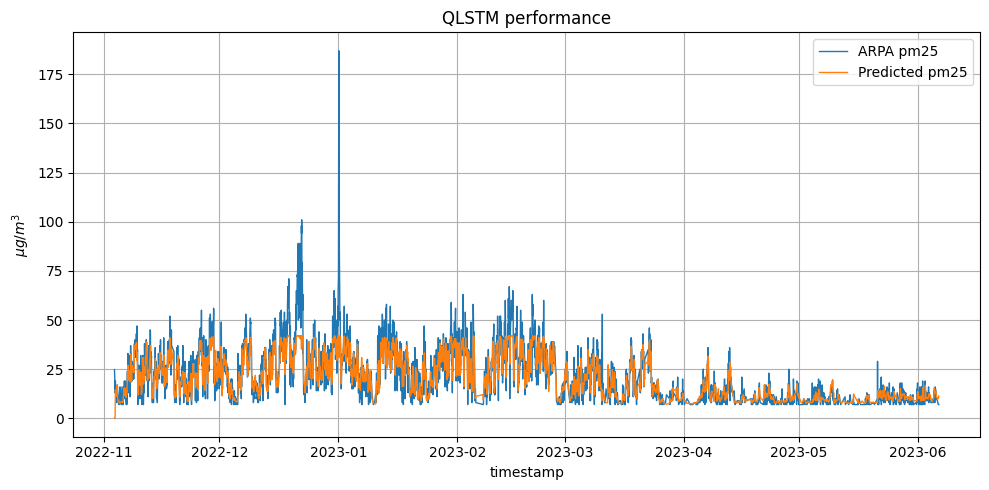

In [167]:
plot_df = df[['timestamp', 'y', 'y_pred']]
plot_df.set_index('timestamp', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(plot_df['y'], label='ARPA pm25', linewidth=1)
ax.plot(plot_df['y_pred'], label='Predicted pm25', linewidth=1)
ax.set_xlabel('timestamp')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title(f'QLSTM performance')
ax.legend(loc='upper right')
ax.grid()
fig.tight_layout()
plt.show()

## LSTM depowered

In [51]:
# Build the same dataset
df, _ = build_dataset_hourly()
input_data = df.drop(['timestamp'], axis=1)
targets = df.y.values

In [52]:
from utils.tuning_utils import TuningUtils
from model.train.LSTM_trainer import LSTM_trainer
from model.LSTM import MyLSTM
from model.train.hyperparams.lstm_hyperparams import LSTM_Hyperparameters

hyperparams = LSTM_Hyperparameters(
    {
        'TRAIN_SIZE': 0.70,
        'LEARNING_RATE': 0.001,
        'OPTIMIZER': 'rmsprop',
        'CRITERION': 'l1',
        'HIDDEN_SIZE': 15,
        'NUM_EPOCHS': 300,
        'T': 3
    }
)
model = MyLSTM(input_data.shape[1], hyperparams['HIDDEN_SIZE'], 2, hyperparams['OUTPUT_SIZE'])
model.load_state_dict(
    torch.load('../model/checkpoints/LSTM-QLSTM_TUNING_20240208_234244/LSTM-QLSTM_TUNING_20240208_234244_2024-02-08_23-49.pt'))

optimizer = TuningUtils.choose_optimizer(hyperparams.hyperparameters, model)
criterion = TuningUtils.choose_criterion(hyperparams.hyperparameters)
trainer = LSTM_trainer(model, name='LSTM_model', hyperparameters=hyperparams, optimizer=optimizer, criterion=criterion)
# count weights
sum_weights = 0
for i in model.named_parameters():
    print(len(i[1]), i[0])
    sum_weights += len(i[1])
print('Total weights', sum_weights)

LSTM_model - Using cpu device
60 rnn.weight_ih_l0
60 rnn.weight_hh_l0
60 rnn.bias_ih_l0
60 rnn.bias_hh_l0
60 rnn.weight_ih_l1
60 rnn.weight_hh_l1
60 rnn.bias_ih_l1
60 rnn.bias_hh_l1
1 fc.weight
1 fc.bias
Total weights 482


In [53]:
D = input_data.shape[1]
N = len(input_data) - hyperparams['T']
X = np.zeros((N, hyperparams['T'], D))
for t in range(N):
    X[t, :, :] = input_data[t:t + hyperparams['T']]
X = torch.from_numpy(X.astype(np.float32))

### Predict values

In [54]:
predictions = trainer.predict(X)
predictions = np.insert(predictions, 0, values=[0 for _ in range(hyperparams['T'])])
df['y_pred'] = predictions
df_final['y_lstm-d'] = predictions

### Plot the LSTM-d values

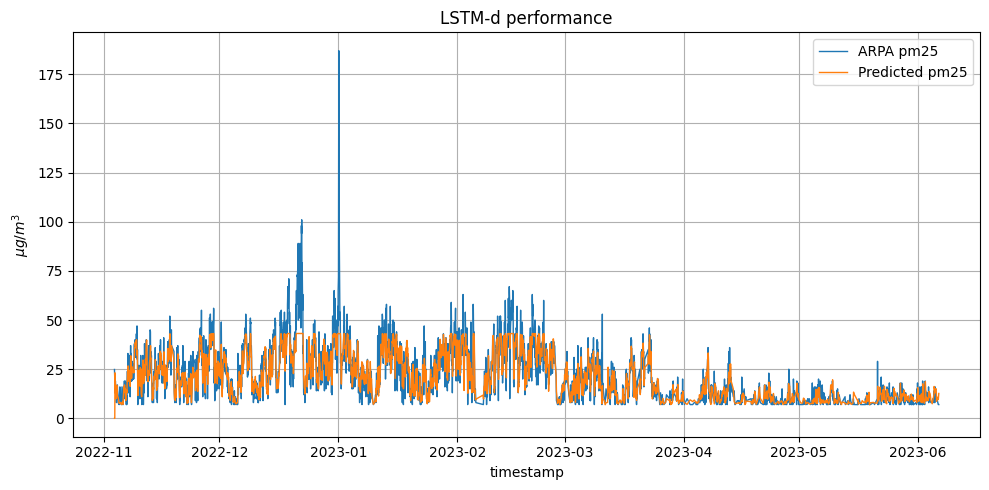

In [238]:
plot_df = df[['timestamp', 'y', 'y_pred']]
plot_df.set_index('timestamp', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(plot_df['y'], label='ARPA pm25', linewidth=1)
ax.plot(plot_df['y_pred'], label='Predicted pm25', linewidth=1)
ax.set_xlabel('timestamp')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title(f'LSTM-d performance')
ax.legend(loc='upper right')
ax.grid()
fig.tight_layout()
plt.show()

## Plot all the models together

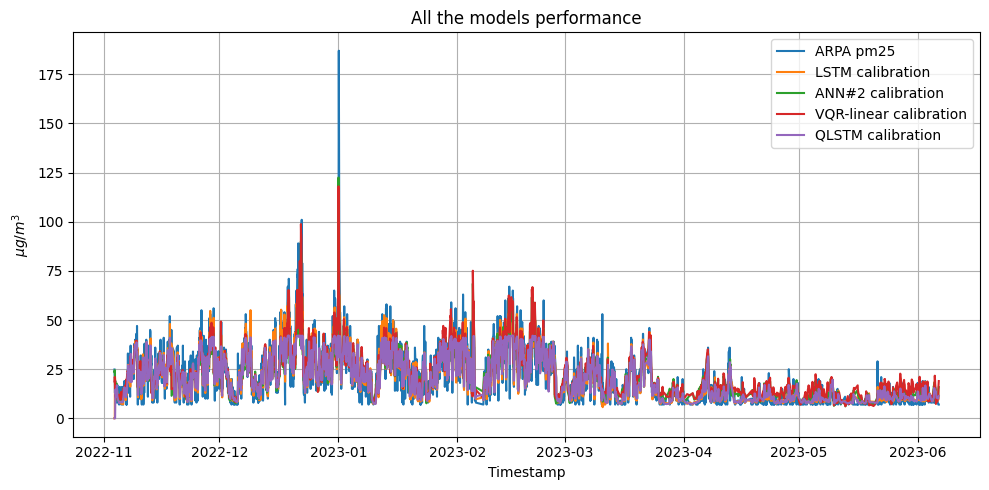

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=df_final, x="timestamp", y="y", ax=ax, label='ARPA pm25')
sns.lineplot(data=df_final, x="timestamp", y="y_lstm", ax=ax, label='LSTM calibration')
sns.lineplot(data=df_final, x="timestamp", y="y_ann", ax=ax, label='ANN#2 calibration')
sns.lineplot(data=df_final, x="timestamp", y="y_vqr", ax=ax, label='VQR-linear calibration')
sns.lineplot(data=df_final, x="timestamp", y="y_qlstm", ax=ax, label='QLSTM calibration')

ax.set_xlabel('Timestamp')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title(f'All the models performance')
ax.grid()
fig.tight_layout()
plt.show()

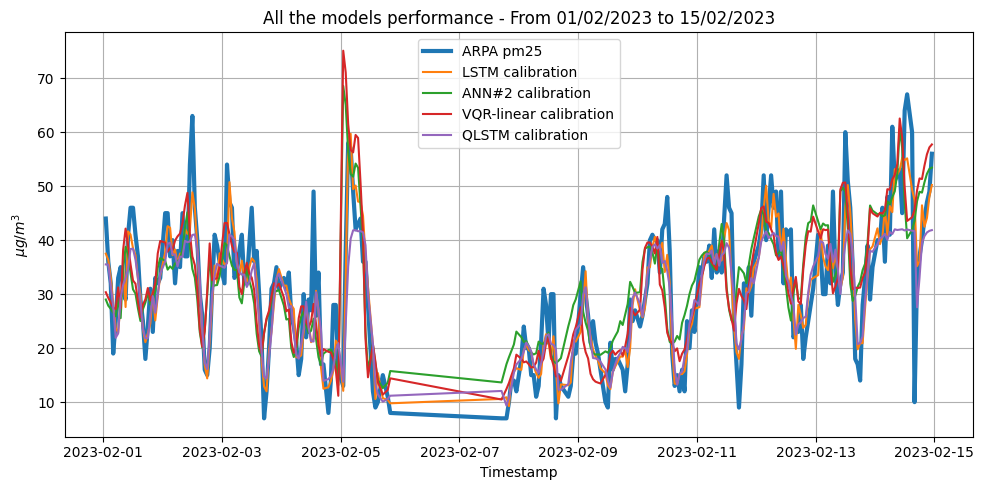

In [190]:
df_final_filtered = df_final[(df_final['timestamp'] > '2023-02-01 00:00:00') & (df_final['timestamp'] < '2023-02-15 00:00:00')]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=df_final_filtered, x="timestamp", y="y", ax=ax, label='ARPA pm25', linewidth=3)
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_lstm", ax=ax, label='LSTM calibration')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_ann", ax=ax, label='ANN#2 calibration')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_vqr", ax=ax, label='VQR-linear calibration')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_qlstm", ax=ax, label='QLSTM calibration')

ax.set_xlabel('Timestamp')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title(f'All the models performance - From 01/02/2023 to 15/02/2023')
ax.grid()
fig.tight_layout()
plt.show()

### Graph LSTM-d wrt QLSTM

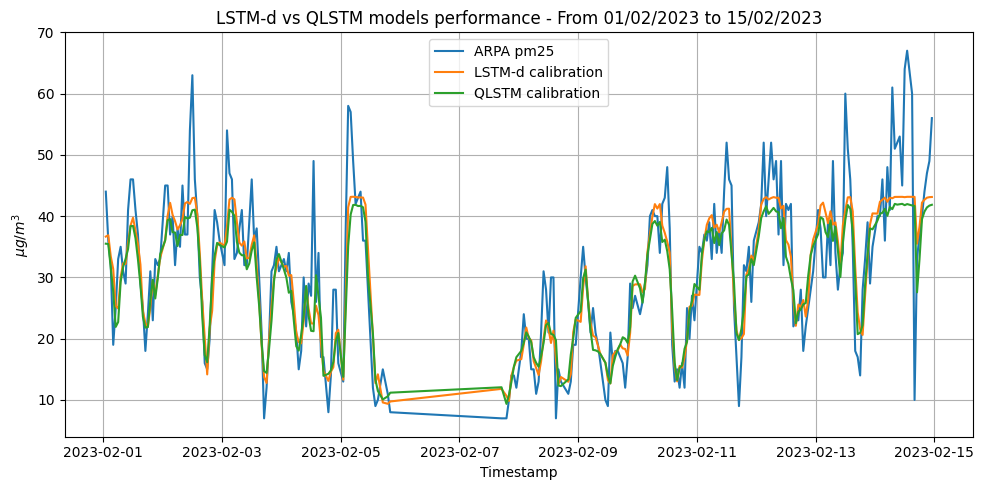

In [244]:
df_final_filtered = df_final[(df_final['timestamp'] > '2023-02-01 00:00:00') & (df_final['timestamp'] < '2023-02-15 00:00:00')]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=df_final_filtered, x="timestamp", y="y", ax=ax, label='ARPA pm25')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_lstm-d", ax=ax, label='LSTM-d calibration')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_qlstm", ax=ax, label='QLSTM calibration')

ax.set_xlabel('Timestamp')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title(f'LSTM-d vs QLSTM models performance - From 01/02/2023 to 15/02/2023')
ax.grid()
fig.tight_layout()
plt.show()

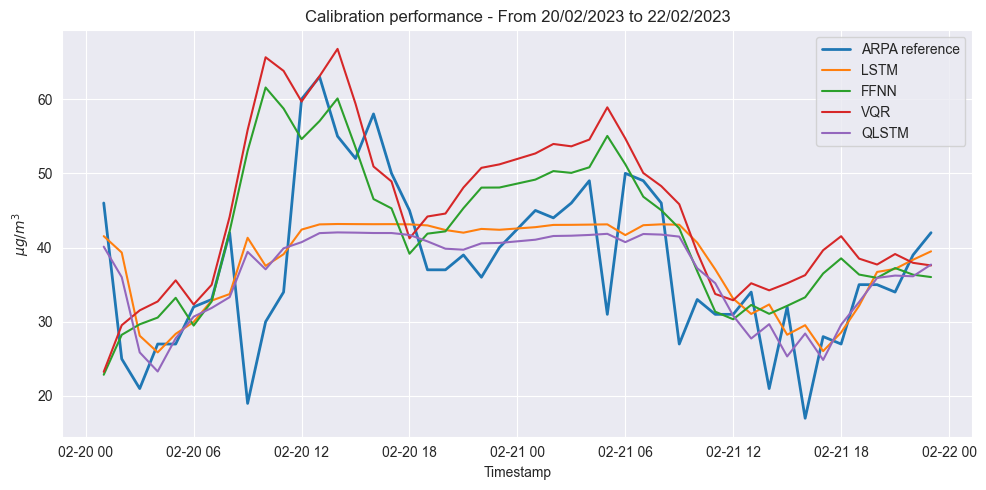

In [40]:
df_final_filtered = df_final[(df_final['timestamp'] > '2023-02-20 00:00:00') & (df_final['timestamp'] < '2023-02-22 00:00:00')]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=df_final_filtered, x="timestamp", y="y", ax=ax, label='ARPA reference', linewidth=2)
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_lstm-d", ax=ax, label='LSTM')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_ann", ax=ax, label='FFNN')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_vqr", ax=ax, label='VQR')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_qlstm", ax=ax, label='QLSTM')

ax.set_xlabel('Timestamp')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title(f'Calibration performance - From 20/02/2023 to 22/02/2023')
ax.grid()
fig.tight_layout()
plt.grid()
plt.savefig("all-models-performance-filtered.svg", format='svg')
plt.show()

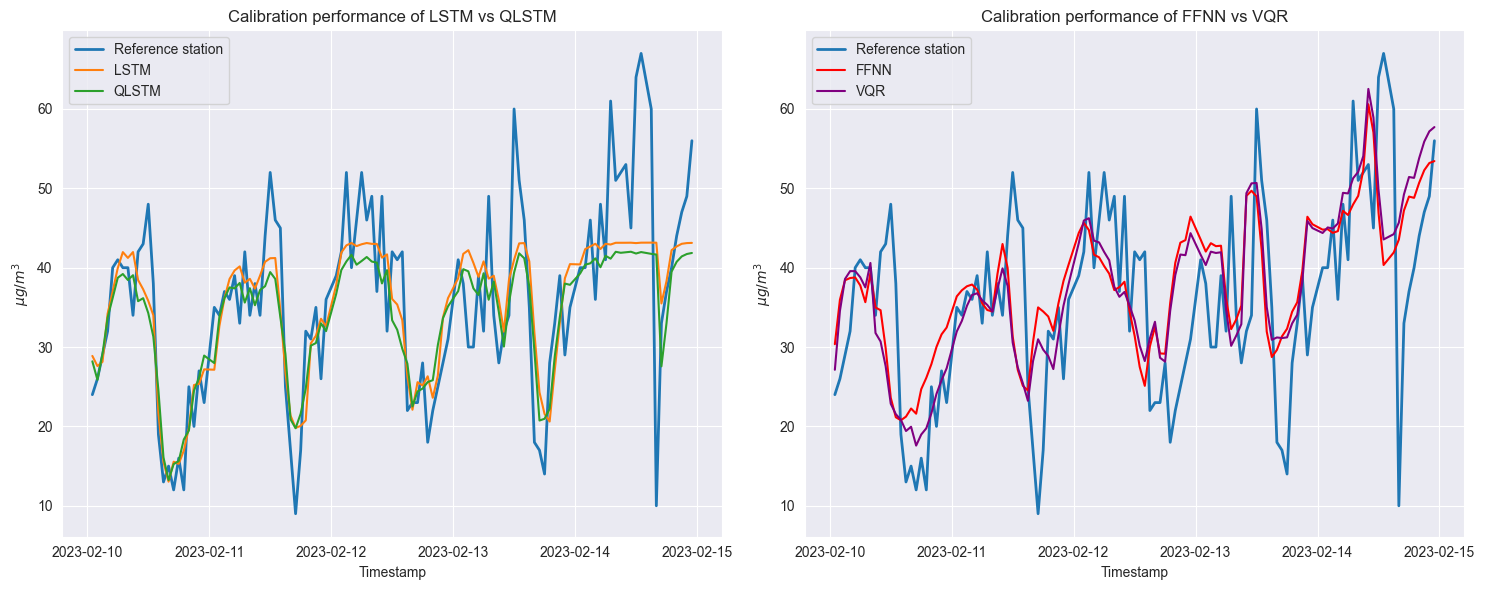

In [47]:
df_final_filtered = df_final[(df_final['timestamp'] > '2023-02-10 00:00:00') & (df_final['timestamp'] < '2023-02-15 00:00:00')]
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(data=df_final_filtered, x="timestamp", y="y", ax=ax[0], label='Reference station', linewidth=2)
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_lstm-d", ax=ax[0], label='LSTM')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_qlstm", ax=ax[0], label='QLSTM')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y", ax=ax[1], label='Reference station', linewidth=2)
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_ann", ax=ax[1], label='FFNN', color='red')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_vqr", ax=ax[1], label='VQR', color='purple')

ax[0].set_xlabel('Timestamp')
ax[0].set_ylabel(r'$\mu g/m^3$')
ax[0].set_title(f'Calibration performance of LSTM vs QLSTM')
ax[1].set_xlabel('Timestamp')
ax[1].set_ylabel(r'$\mu g/m^3$')
ax[1].set_title(f'Calibration performance of FFNN vs VQR')
ax[1].grid()
fig.tight_layout()
plt.grid()
plt.savefig("all-models-performance-filtered.svg", format='svg')
plt.show()

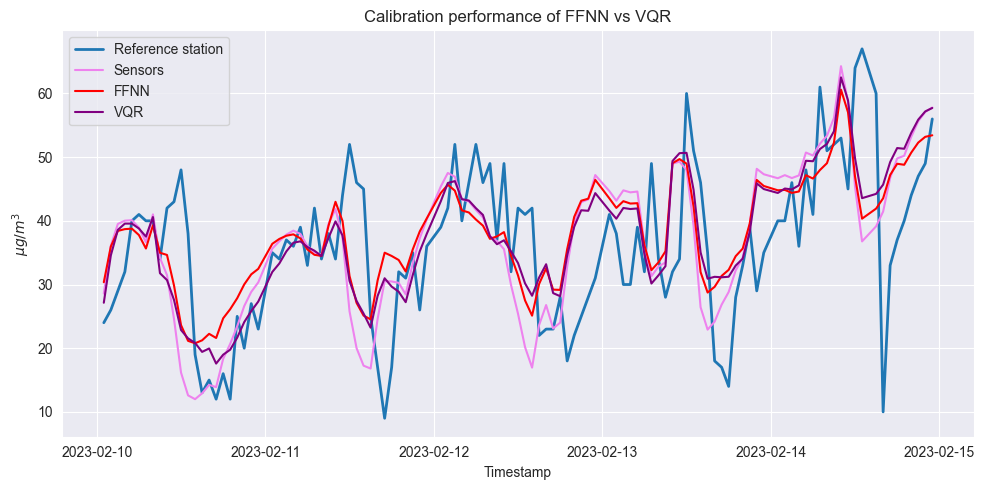

In [59]:
df_final_filtered = df_final[(df_final['timestamp'] > '2023-02-10 00:00:00') & (df_final['timestamp'] < '2023-02-15 00:00:00')]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=df_final_filtered, x="timestamp", y="y", ax=ax, label='Reference station', linewidth=2)
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_sensor", ax=ax, label='Sensors', color='violet')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_ann", ax=ax, label='FFNN', color='red')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_vqr", ax=ax, label='VQR', color='purple')

ax.set_xlabel('Timestamp')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title(f'Calibration performance of FFNN vs VQR')
ax.grid()
fig.tight_layout()
plt.grid()
plt.savefig("ffnn-vqr-models-performance.svg", format='svg')
plt.show()

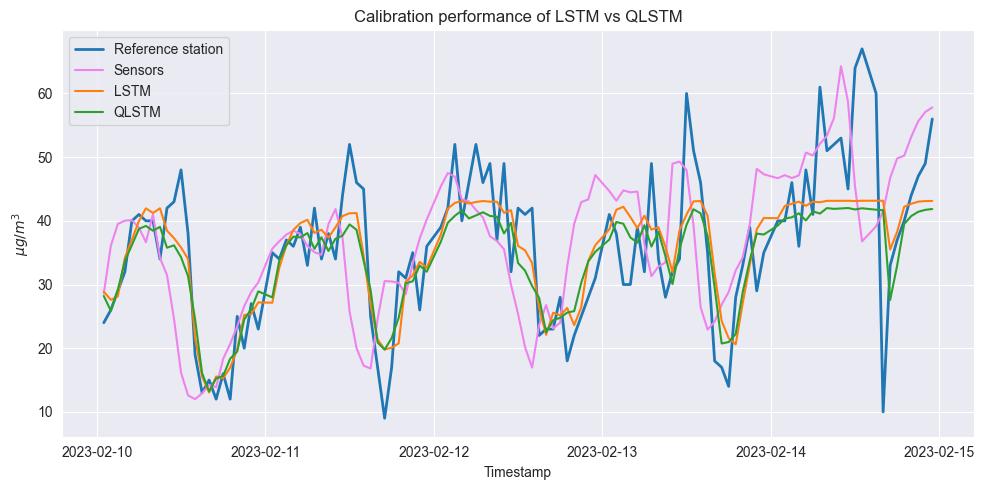

In [60]:
df_final_filtered = df_final[(df_final['timestamp'] > '2023-02-10 00:00:00') & (df_final['timestamp'] < '2023-02-15 00:00:00')]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=df_final_filtered, x="timestamp", y="y", ax=ax, label='Reference station', linewidth=2)
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_sensor", ax=ax, label='Sensors', color='violet')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_lstm-d", ax=ax, label='LSTM')
sns.lineplot(data=df_final_filtered, x="timestamp", y="y_qlstm", ax=ax, label='QLSTM')

ax.set_xlabel('Timestamp')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title(f'Calibration performance of LSTM vs QLSTM')
ax.grid()
fig.tight_layout()
plt.grid()
plt.savefig("lstm-qlstm-models-performance.svg", format='svg')
plt.show()

### Compute the loss of all the models

In [79]:
from model.loss_functions.RMSELoss import RMSELoss

CRITERION_RMSE   = RMSELoss()
CRITERION_L1   = nn.L1Loss()

y = df_final['y'].values
X_ann = df_final['y_ann'].values
X_vqr = df_final['y_vqr'].values
X_lstm = df_final['y_lstm'].values
X_qlstm = df_final['y_qlstm'].values
X_lstm_d = df_final['y_lstm-d'].values

print('ANN', CRITERION_L1(torch.from_numpy(X_ann.astype(np.float32)), torch.from_numpy(y.astype(np.float32))).item())
print('VQR', CRITERION_L1(torch.from_numpy(X_vqr.astype(np.float32)), torch.from_numpy(y.astype(np.float32))).item())
print('LSTM', CRITERION_L1(torch.from_numpy(X_lstm.astype(np.float32)), torch.from_numpy(y.astype(np.float32))).item())
print('QLSTM', CRITERION_L1(torch.from_numpy(X_qlstm.astype(np.float32)), torch.from_numpy(y.astype(np.float32))).item())
print('LSTM-d', CRITERION_L1(torch.from_numpy(X_lstm_d.astype(np.float32)), torch.from_numpy(y.astype(np.float32))).item())

ANN 5.898313522338867
VQR 5.908761024475098
LSTM 3.8371152877807617
QLSTM 4.529757022857666
LSTM-d 4.370097637176514


In [75]:
from sklearn.model_selection import train_test_split
from model.loss_functions.RMSELoss import RMSELoss

# Use only the test-set to compute the loss
CRITERION_RMSE   = RMSELoss()
CRITERION_L1   = nn.L1Loss()
TRAIN_SIZE = 0.75
y = df_final['y'].values

_, X_ann, _, y_ann = train_test_split(df_final['y_ann'].values, y, train_size=TRAIN_SIZE, shuffle=True)
_, X_vqr, _, y_vqr = train_test_split(df_final['y_vqr'].values, y, train_size=TRAIN_SIZE, shuffle=True)
_, X_lstm, _, y_lstm = train_test_split(df_final['y_lstm'].values, y, train_size=TRAIN_SIZE, shuffle=True)
_, X_qlstm, _, y_qlstm = train_test_split(df_final['y_qlstm'].values, y, train_size=TRAIN_SIZE, shuffle=True)
_, X_lstm_d, _, y_lstm_d = train_test_split(df_final['y_lstm-d'].values, y, train_size=TRAIN_SIZE, shuffle=True)

print('ANN', CRITERION_RMSE(torch.from_numpy(X_ann.astype(np.float32)), torch.from_numpy(y_ann.astype(np.float32))).item())
print('VQR', CRITERION_RMSE(torch.from_numpy(X_vqr.astype(np.float32)), torch.from_numpy(y_vqr.astype(np.float32))).item())
print('LSTM', CRITERION_RMSE(torch.from_numpy(X_lstm.astype(np.float32)), torch.from_numpy(y_lstm.astype(np.float32))).item())
print('QLSTM', CRITERION_RMSE(torch.from_numpy(X_qlstm.astype(np.float32)), torch.from_numpy(y_qlstm.astype(np.float32))).item())
print('LSTM-d', CRITERION_RMSE(torch.from_numpy(X_lstm_d.astype(np.float32)), torch.from_numpy(y_lstm_d.astype(np.float32))).item())

ANN 8.608075141906738
VQR 8.381258964538574
LSTM 5.50275182723999
QLSTM 7.434832572937012
LSTM-d 8.292451858520508


In [55]:
vqr_l1_losses = []
ann_l1_losses = []
for _ in range(10000):
    _, X_vqr, _, y_vqr = train_test_split(df_final['y_vqr'].values, y, train_size=TRAIN_SIZE, shuffle=True)
    _, X_ann, _, y_ann = train_test_split(df_final['y_ann'].values, y, train_size=TRAIN_SIZE, shuffle=True)
    vqr_l1_losses.append(CRITERION_L1(torch.from_numpy(X_vqr.astype(np.float32)), torch.from_numpy(y_vqr.astype(np.float32))).item())
    ann_l1_losses.append(CRITERION_L1(torch.from_numpy(X_ann.astype(np.float32)), torch.from_numpy(y_ann.astype(np.float32))).item())
    
print(np.array(vqr_l1_losses).mean())
print(np.array(ann_l1_losses).mean())

5.908298905134201
5.901538669681549


In [48]:
from sklearn.metrics import r2_score

# Uso Adj-R2
r2 = r2_score(y, X_lstm_d)
adj_r2 = 1-(1-r2)*(len(X_lstm_d) - 1)/(len(X_lstm_d) - 1 - 1)
print(adj_r2)

r2 = r2_score(y, X_qlstm)
adj_r2 = 1-(1-r2)*(len(X_qlstm) - 1)/(len(X_qlstm) - 1 - 1)
print(adj_r2)

r2 = r2_score(y, X_lstm)
adj_r2 = 1-(1-r2)*(len(X_lstm) - 1)/(len(X_lstm) - 1 - 1)
print(adj_r2)

ValueError: Found input variables with inconsistent numbers of samples: [3683, 921]